## Importing the libraries

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import itertools    
import matplotlib.pyplot as plt
import random


from sklearn.utils import resample
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras

from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential

import mdn
import RBF_NN as RBF

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
random.seed(42)

## Auxiliary functions

#### Performance metrics

In [3]:
def performance_metrics(output, prediction):

    p_m = [
        accuracy_score(output, prediction),
        precision_score(output, prediction, average = 'macro'),
        recall_score(output, prediction, average = 'macro'),
        f1_score(output, prediction, average = 'macro')
    ]

    return p_m

#### Confusion matrix

In [4]:
def conf_matrix(output,Prediction, Case):    
    conf = confusion_matrix(output, Prediction)
    plt.figure()
 
    classes = [0, 1, 2]
    # plot confusion matrix
    plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = conf.max() / 2.
    for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
        plt.text(j, i, format(conf[i, j], fmt),
                horizontalalignment="center",
                color="white" if conf[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Plots/Confusion_Matrix/CM_' + Case + ".pdf", format="pdf",bbox_inches="tight")

#### Total performance

In [5]:
def final_performance(model, input, output, Case, MDN = 'False', n_mixes = 10):
    ## Dataset
    if MDN == 'False':
        TrainPredictions = model.predict(input)
        TrainPredictions = np.argmax(TrainPredictions, axis=1)
    else:
        y_test = model.predict(input)
        TrainPredictions = np.apply_along_axis(mdn.sample_from_output, 1, y_test, 3, n_mixes, temp=1.0)
        TrainPredictions = TrainPredictions.argmax(axis = 2)

    ## Confusion Matrix
    conf_matrix(output, TrainPredictions, Case)

    ## Performance Metrics
    PM = performance_metrics(output, TrainPredictions)


    ## Classification Reports
    #print("\n Classification report for " + Case + '\n')
    #print(classification_report(output, TrainPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

    return PM

#### Neural Network

In [6]:
def fit_model(X_train, y_train, X_test, y_test, NN,  
              class_weights = dict(enumerate([1,1,1])),
              epochs = 5000, batch_size = 200, lr = 0.001, wd = 0.0001, 
              patience = 500, layers = [256,256,256], 
              activ = "tanh", N_RBF = 3, beta = 1, n_mixes = 3):
    
    Case = NN
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=patience)
    # define model
    model = tf.keras.Sequential()
    if NN == 'MLP':
        model.add(keras.layers.Dense(layers[0], 
                                    activation= activ, 
                                    input_shape=(X_train.shape[-1],)))
        
        for i in range(1,len(layers)):
            model.add(keras.layers.Dense(layers[i], activation= activ))
            model.add(keras.layers.Dropout(0.3))
        model.add(keras.layers.Dense(3, activation = 'sigmoid'))
        lf = "categorical_crossentropy"

        
    elif NN == 'RBF':
        rbflayer = RBF.RBFLayer(N_RBF,
                            initializer=RBF.InitCentersKMeans(X_train),
                            betas= beta,
                            input_shape=(np.shape(X_train)[1],))
        model.add(rbflayer)
        model.add(keras.layers.Dense(3, activation = 'sigmoid'))
        lf = "categorical_crossentropy"

    elif NN == 'MDN':
        for i in range(1,len(layers)):
            model.add(keras.layers.Dense(layers[i], activation= activ))
        
        model.add(mdn.MDN(3, n_mixes))
        lf = mdn.get_mixture_loss_func(3,  n_mixes)

    opt = Adam(learning_rate = lr, decay = wd)

    model.compile(loss= lf, 
                  optimizer=opt)
    
    # fit model
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=epochs,  
                        batch_size=batch_size, 
                        verbose=0, 
                        callbacks=[early_stop],
                        class_weight= class_weights
                        )

    # Plotting the results
    plt.figure()
    plt.semilogy(history.history['loss'], label='train')
    plt.semilogy(history.history['val_loss'], label='test')
    plt.legend()
    plt.grid()
    plt.ylabel('Loss function [-]')
    plt.xlabel('Epochs [-]')
    plt.savefig("Plots/History/History_" + Case + ".pdf",format = 'pdf', bbox_inches='tight')

    return model, history

## Pre-processing the data

### Loading the data

Based on the Thyroid Disease database avaliable at https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease

### Training Data

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTrain.head()

print(dataTrain.shape)
dataTrain.head()

(3772, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


##### Removing missing Data

In [8]:
del dataTrain[22]
del dataTrain[23]
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


##### Separating the Data

In [9]:
#Predictor data
inputTrain = dataTrain.drop([21], axis=1)

#Target data
outputTrain = dataTrain[21] - 1     

### Test Data

In [10]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTest.head()

print(dataTest.shape)
dataTest.head()

(3428, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


##### Revoving missing Data

In [11]:
del dataTest[22]
del dataTest[23]
dataTest.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0061,0.028,0.111,0.131,0.085,2
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0013,0.019,0.084,0.078,0.107,3
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0000,0.031,0.239,0.100,0.239,3
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0010,0.018,0.087,0.088,0.099,3
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0.0004,0.022,0.134,0.135,0.099,3


##### Separating the Data

In [12]:
# Predictor data
inputTest = dataTest.drop([21], axis=1)

# Target data 
outputTest = dataTest[21] - 1

### Data normalization

In [13]:
# MinMax Scaller
scaler = preprocessing.MinMaxScaler()

# fit using the train set
scaler.fit(inputTrain)

# transform the test test
xtrainN = scaler.transform(inputTrain)
xtestN = scaler.transform(inputTest) 

### Encoding the target data

In [14]:
outputTrain_one_hot = keras.utils.to_categorical(outputTrain)

### Class imbalance

In [15]:
print("Proportion of classes in the dataset")
counts = np.bincount(outputTrain)

print(counts)
print("Training set:",  counts/ float(len(outputTrain)))
print("Test set:", np.bincount(outputTest) / float(len(outputTest)))

weights_class1 = 1.0/counts[0]
weights_class2 = 1.0/counts[1]
weights_class3 = 1.0/counts[2]

class_weights = compute_class_weight('balanced', 
                                     classes = np.unique(outputTrain), 
                                     y = outputTrain)
print(class_weights)

d_class_weights = dict(enumerate(class_weights))

Proportion of classes in the dataset
[  93  191 3488]
Training set: [0.02465536 0.05063627 0.92470838]
Test set: [0.02129522 0.05163361 0.92707118]
[13.51971326  6.58289703  0.36047401]


### Train - Validation Split

In [16]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
                                                                                xtrainN, 
                                                                                outputTrain_one_hot, 
                                                                                test_size = 0.3, 
                                                                                random_state = 1, 
                                                                                stratify=outputTrain
                                                                                )  

### Case 1 - Base

108/108 [==============================] - 0s 1ms/step


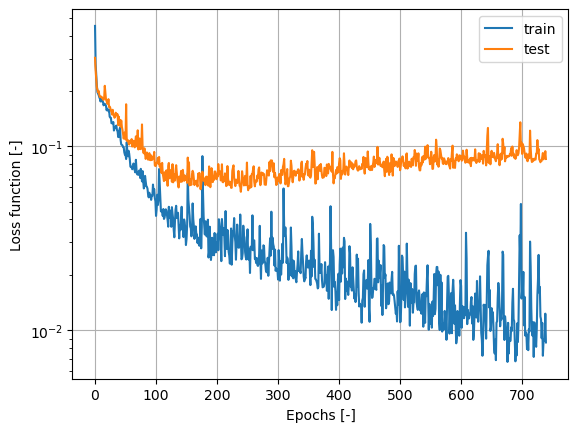

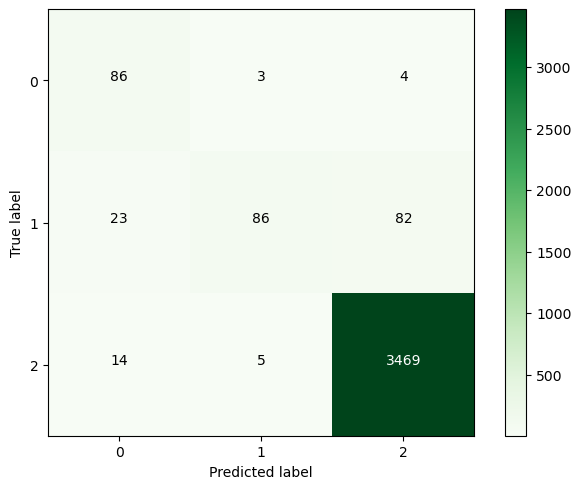

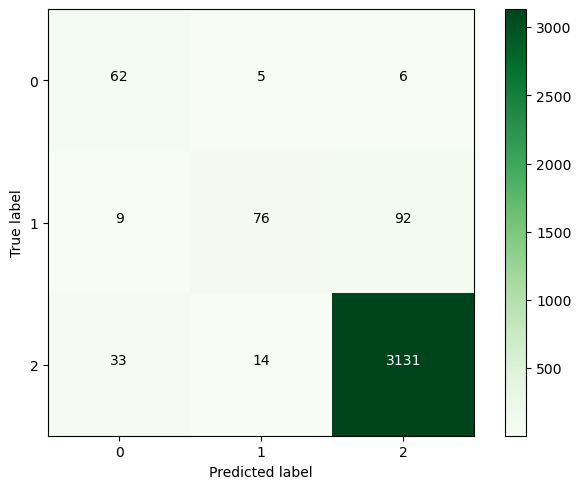

In [17]:
## Performance metrics array

PM_train = []
PM_test = []

Data = {
    'epochs' : 5000, 
    'batch_size': 200,
    'lr' : 0.001,
    'patience': 500,
    'layers': [256,256,256],
    'activ': "tanh"
    }

NN = "MLP"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN,  **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_train'))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_test'))

## Radial Basis Networks

In [18]:
import RBF_NN as RBF

Implementation available at https://github.com/raaaouf/RBF_neural_network_python 

c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(None, 21)
(None, 21)
(None, 21)
(None, 21)
(None, 21)
108/108 [==============================] - 0s 2ms/step


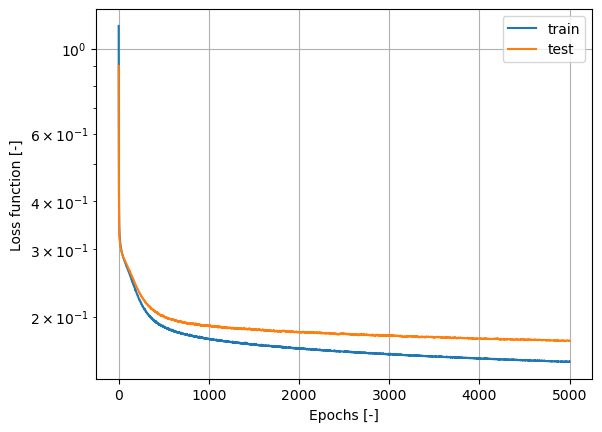

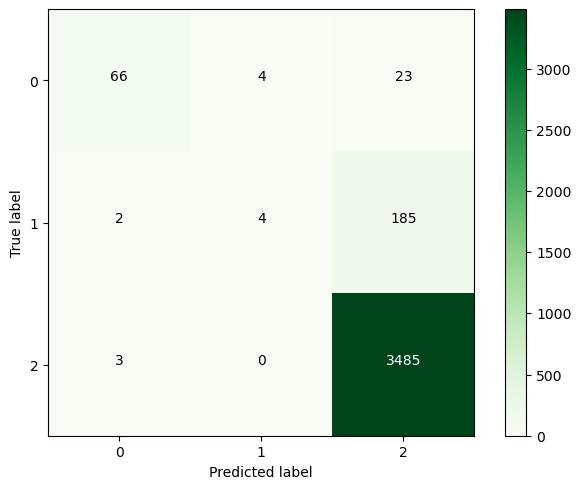

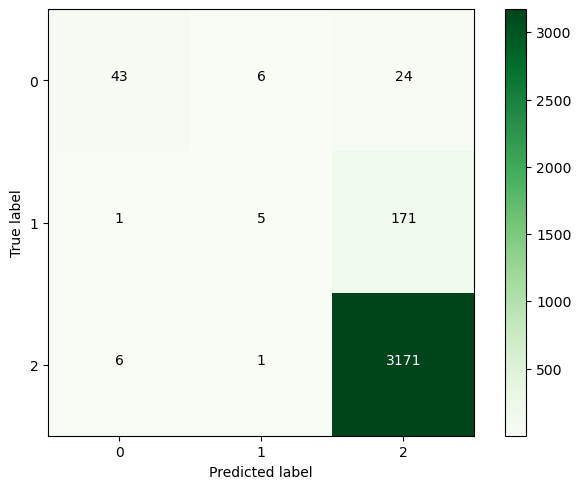

In [19]:
## Performance metrics array

Data = {
    'N_RBF': 50, 
    'beta': 0.5
    }


NN = "RBF"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_train'))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_test'))

c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(None, 21)
(None, 21)
(None, 21)
(None, 21)
(None, 21)
108/108 [==============================] - 0s 3ms/step


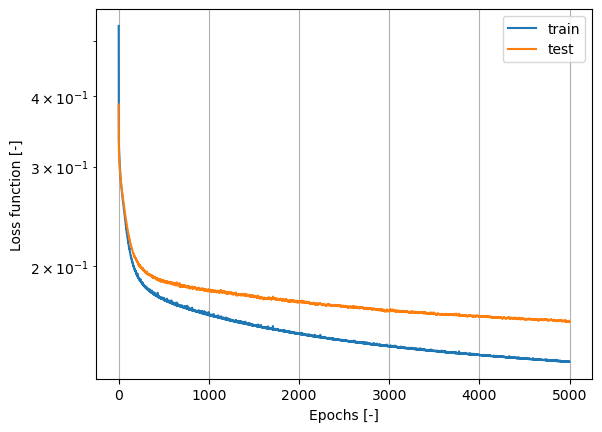

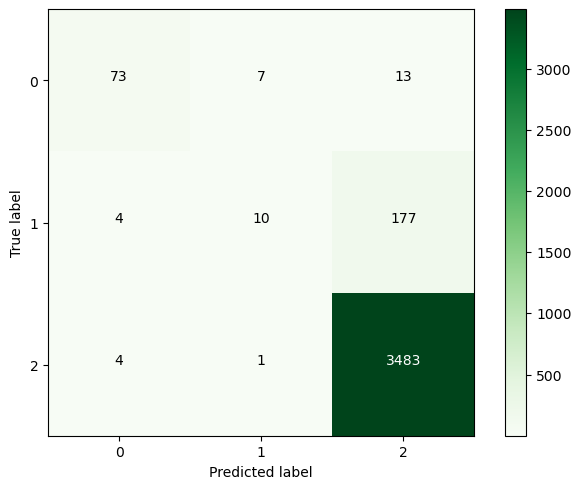

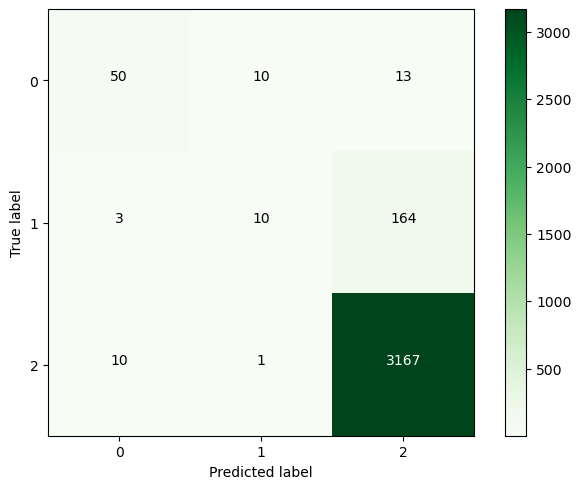

In [20]:
## Performance metrics array

Data = {
    'N_RBF': 100, 
    'beta': 0.5
    }


NN = "RBF"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_N100_train'))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_N100_test'))

c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(None, 21)
(None, 21)
(None, 21)
(None, 21)
(None, 21)
108/108 [==============================] - 0s 848us/step


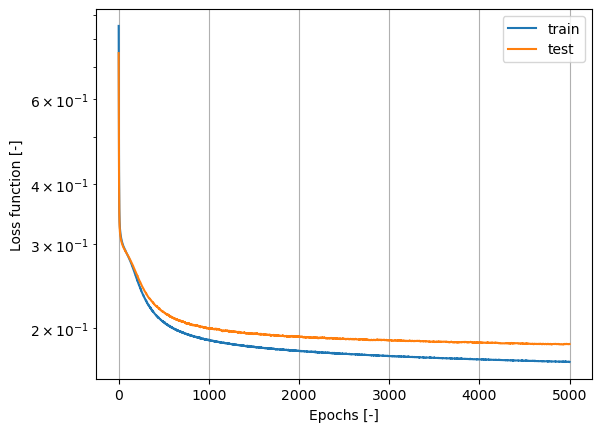

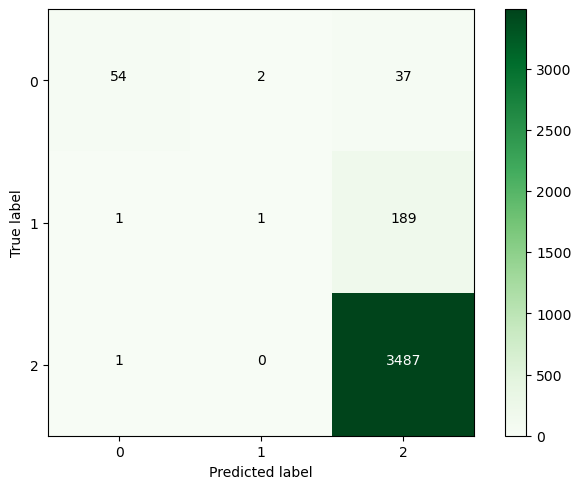

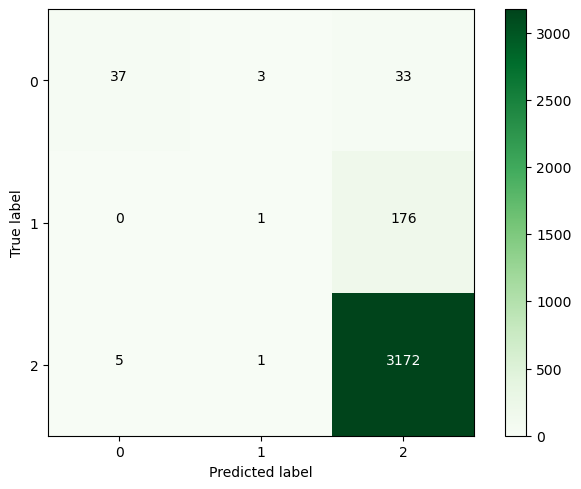

In [21]:
## Performance metrics array

Data = {
    'N_RBF': np.shape(X_train)[1], 
    'beta': 0.5
    }


NN = "RBF"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_NMin_train'))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_Nmin_test'))

c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(None, 21)
(None, 21)
(None, 21)
(None, 21)
(None, 21)
108/108 [==============================] - 0s 849us/step


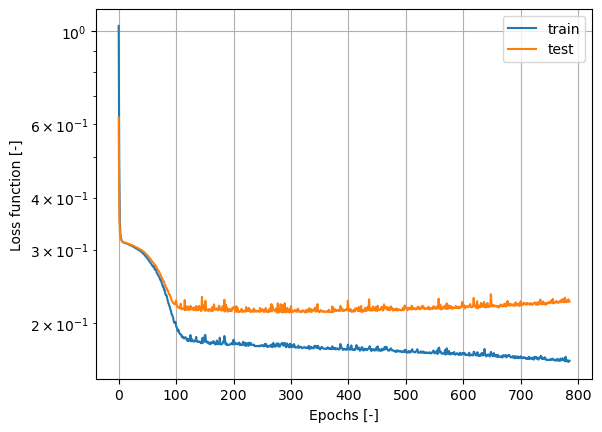

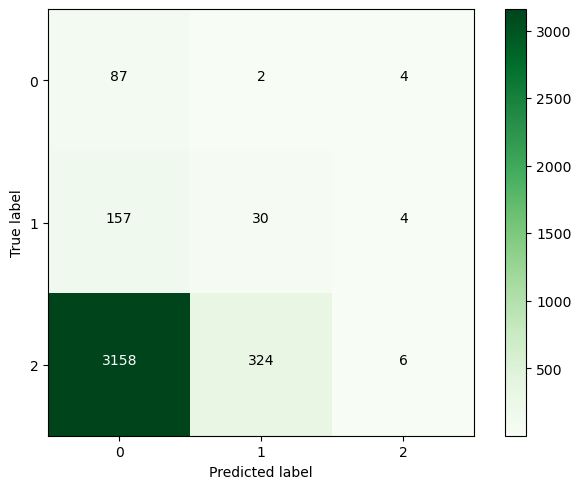

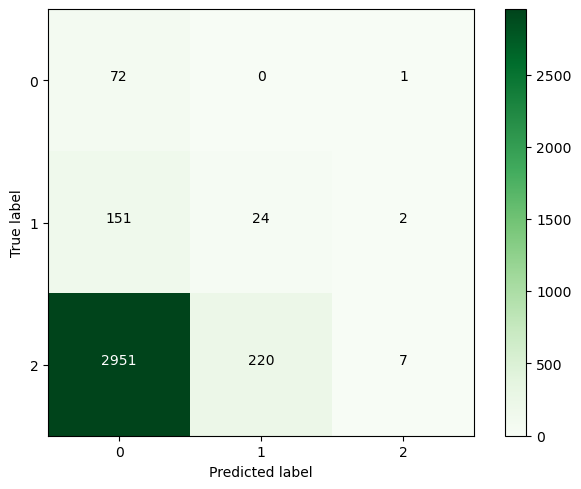

In [22]:
## Performance metrics array

Data = {
    'N_RBF': 50, 
    'beta': 0.01
    }


NN = "RBF"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_b001_train'))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_b001_test'))

c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(None, 21)
(None, 21)
(None, 21)
(None, 21)
(None, 21)
108/108 [==============================] - 0s 990us/step


c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


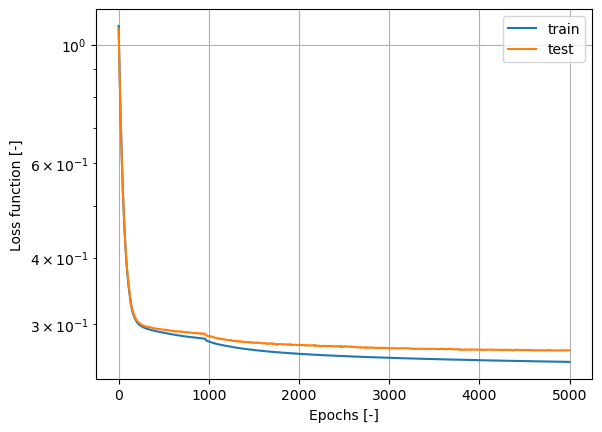

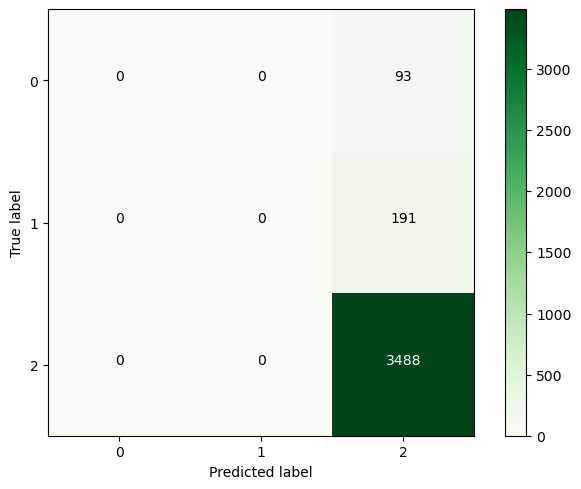

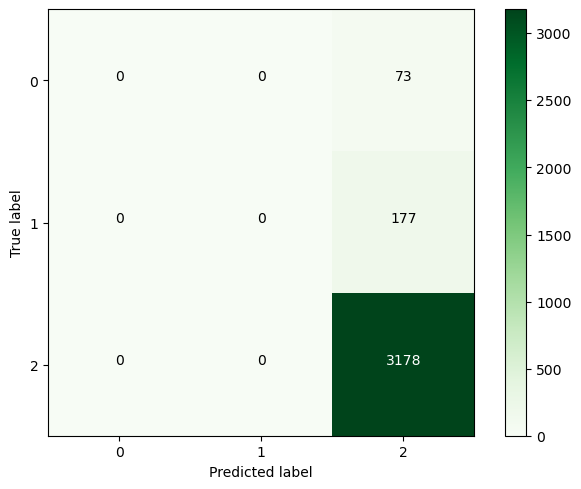

In [23]:
## Performance metrics array

Data = {
    'N_RBF': 50, 
    'beta': 100
    }


NN = "RBF"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_b100_train'))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_b100_test'))

## Misture Density Network

Implementation available at: https://github.com/cpmpercussion/keras-mdn-layer

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


108/108 [==============================] - 0s 959us/step


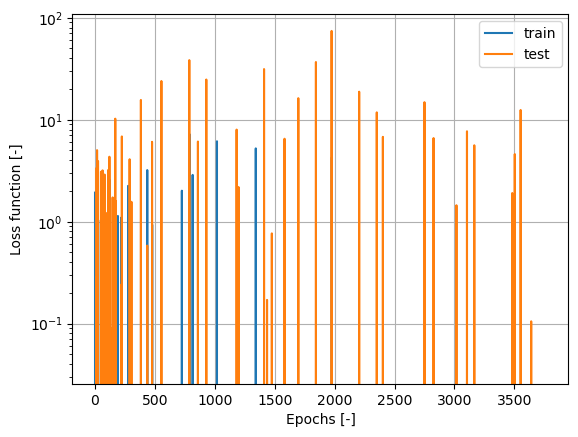

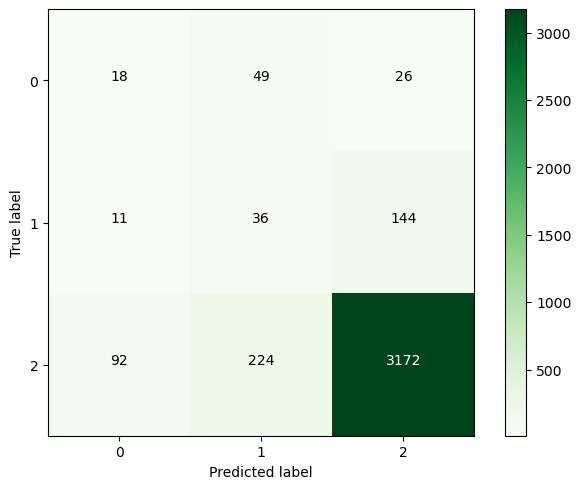

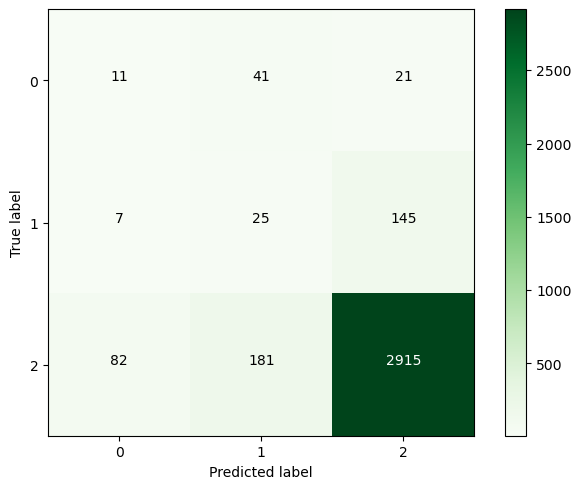

In [24]:
## Performance metrics array

Data = {
    'n_mixes': 20
    }


NN = "MDN"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_train', MDN = True, n_mixes = Data['n_mixes']))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_test', MDN = True, n_mixes = Data['n_mixes']))


108/108 [==============================] - 0s 2ms/step


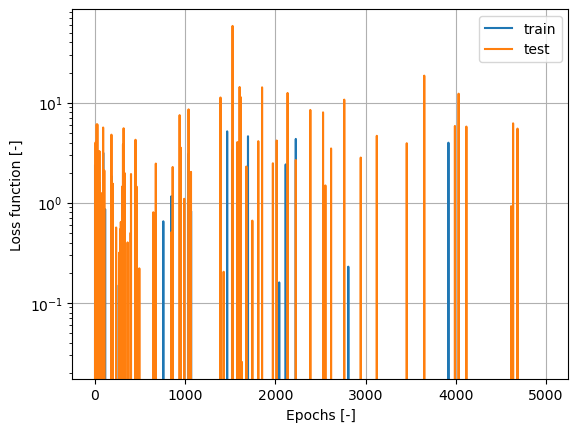

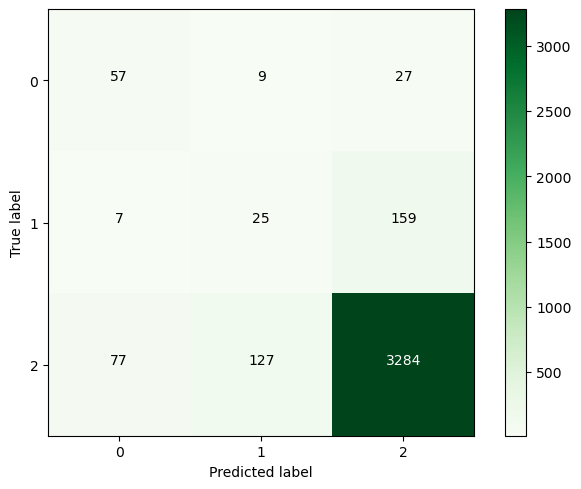

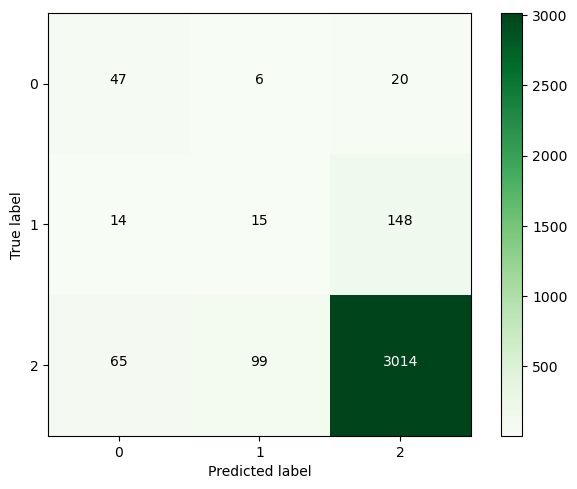

In [25]:
## Performance metrics array

Data = {
    'n_mixes': 100
    }


NN = "MDN"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_N100_train', MDN = True, n_mixes = Data['n_mixes']))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_N100_test', MDN = True, n_mixes = Data['n_mixes']))

108/108 [==============================] - 0s 1ms/step


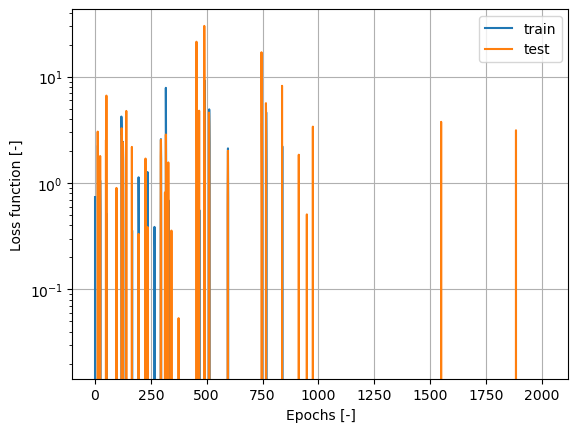

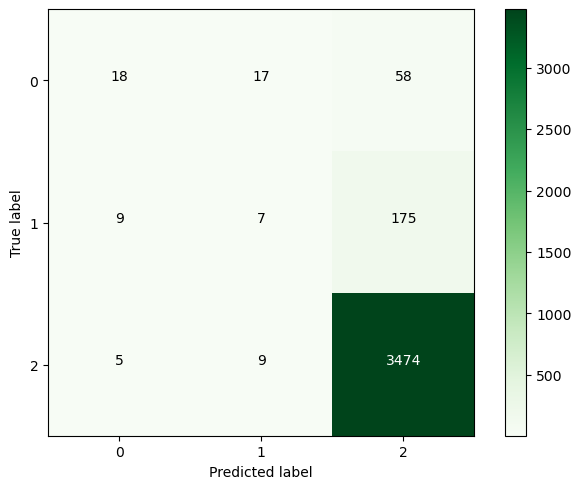

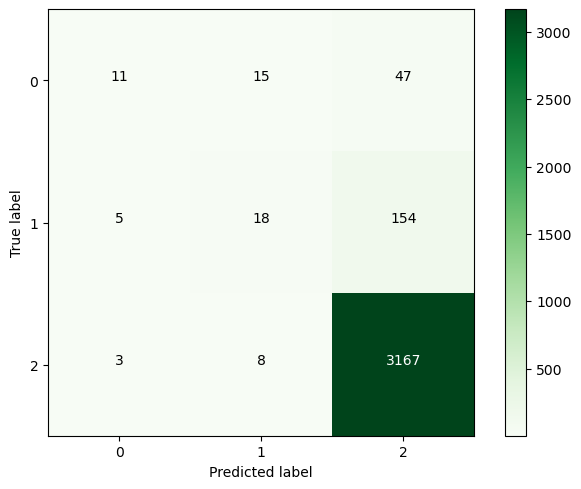

In [26]:
## Performance metrics array

Data = {
    'n_mixes': 3
    }


NN = "MDN"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_N3_train', MDN = True, n_mixes = Data['n_mixes']))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_N3_test', MDN = True, n_mixes = Data['n_mixes']))

108/108 [==============================] - 0s 851us/step


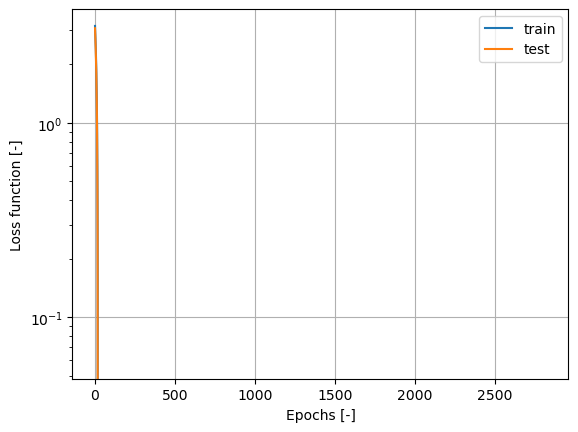

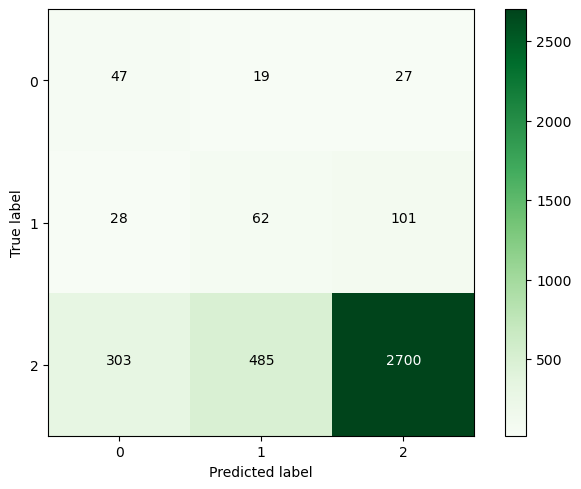

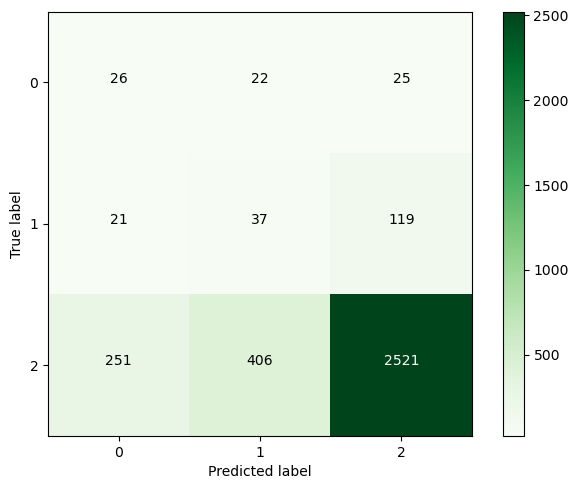

In [27]:
## Performance metrics array

Data = {
    'layers': [0],
    'n_mixes': 20
    }


NN = "MDN"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, NN, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, NN + '_NoDeep_train', MDN = True, n_mixes = Data['n_mixes']))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, NN + '_NoDeep_test', MDN = True, n_mixes = Data['n_mixes']))

In [33]:
## Hyperparameter Optimization Metrics for the training set
pd.DataFrame(PM_train, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).to_excel("Metrics/PM_train.xlsx")
pd.DataFrame(PM_train, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])

,Accuracy,Precision,Recall,F1 Score
0,0.965270,0.863296,0.789849,0.794966
1,0.942471,0.791085,0.576587,0.605232
2,0.945387,0.801687,0.611956,0.635848
3,0.939024,0.745584,0.528531,0.567873
4,0.032609,0.179471,0.364757,0.054300
5,0.924708,0.308236,0.333333,0.320294
6,0.855249,0.404799,0.430478,0.413689
7,0.892365,0.501978,0.561769,0.524391
8,0.927625,0.570589,0.408728,0.438724
9,0.744698,0.396206,0.534689,0.406117


In [34]:
## Hyperparameter Optimization Metrics for the test set
pd.DataFrame(PM_test, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).to_excel("Metrics/PM_test.xlsx")
pd.DataFrame(PM_test, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])

,Accuracy,Precision,Recall,F1 Score
0,0.953617,0.788601,0.754635,0.745586
1,0.939032,0.739578,0.538362,0.573743
2,0.941365,0.738970,0.579322,0.602493
3,0.936406,0.673045,0.503537,0.540563
4,0.030047,0.273682,0.374699,0.054251
5,0.927071,0.309024,0.333333,0.320719
6,0.860852,0.385779,0.403057,0.392184
7,0.897316,0.481740,0.558992,0.507057
8,0.932322,0.652764,0.416306,0.457294
9,0.753792,0.370928,0.452823,0.372780
